In [73]:
# imports

import datetime
import time
import math
import searchtweets
import pandas as pd
import tweepy as tw

import string
import warnings
import datetime
warnings.filterwarnings('ignore')
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to /home/keras/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def get_tweet_object(search_term, start_date, end_date, num_of_tweets, include_retweets=True):
    
    '''
    takes date range, search term & number of tweets
    
    returns tweets object
    
    input search term as a string
    
    input search range as datetime.datetime(20xx, 1, 20)
    
    include_retweets defaults is True. to exclude retweets set to False.
    
    '''
    
    
    search_args = searchtweets.load_credentials('twitter_keys.yaml',
                                                yaml_key='search_tweets_api',
                                                env_overwrite=False)
    
    if include_retweets:
        
        search_term = search_term + ' lang:en'
    
    else:
        
        search_term = search_term + ' lang:en -is:retweet'
        
    
    
    rule = searchtweets.gen_rule_payload(search_term,
                                         results_per_call=500,
                                         from_date=start_date.strftime('%Y-%m-%d'),
                                         to_date=end_date.strftime('%Y-%m-%d'))     
        
    tweet_objects = []
    
    rs = searchtweets.ResultStream(rule_payload=rule,
                                   max_results=num_of_tweets,
                                   max_pages= num_of_tweets / 500,
                                   **search_args)
    
    start_time = time.time()

    for i, tweet_object in enumerate(rs.stream(), start=1):
        
        if i % 500 == 0:
            
            now = time.time()
            
            if now < start_time + 4:
                
                time.sleep(4 - (now - start_time))
                
                start_time = time.time()
                
        tweet_objects.append(tweet_object)
    
    return tweet_objects

def tweet_obj_to_df(tweet_objects):
    
    tweet_dict = {'text': [],
                  'author': []
                 }
    
    for tweet in tweet_objects:
        
        tweet_dict['text'].append(tweet.all_text)
        
        tweet_dict['author'].append(tweet.screen_name)
    
    tweets_df = pd.DataFrame(tweet_dict)
    
    return tweets_df

In [4]:
# tweet_objects = get_tweet_object('query', datetime.datetime(2007,1,24), datetime.datetime(2020,1,24), 100000, include_retweets=False)

P_tweet_objects = get_tweet_object('Pocahontas', datetime.datetime(2018, 1, 1), datetime.datetime(2020, 1, 25), 100000, include_retweets=False)
 

Grabbing bearer token from OAUTH


In [5]:
P_raw_df = tweet_obj_to_df(P_tweet_objects)

print(len(P_raw_df), '\n')

print(P_raw_df.head(25))


100000 

                                                 text           author
0     @nypost Socialist Pocahontas, national disgrace         nateg749
1   @ewarren All about the killin’ isn’t it, Pocah...    CharlyISaLION
2   @wjband @travisakers Just a week or so ago Tra...      BotchedDems
3   @pocahontas_ash_ If you get consistent in the ...      Lito_grimes
4   Angry dad rips Elizabeth Warren over student l...       Maphisto13
5   @OEF_Tr8der @Alyssa_Milano Shhh. The level of ...        rayrothfe
6   @brandonj205 @travisakers They want you to uni...      BotchedDems
7   How did Bambi get a live action remake before ...    stxrryniqhtts
8   @__ashkan_ Great, I would pick Trump over Alzh...       Redpill137
9   @ewarren Fuck you, you no dancing no drinking ...  flintdivebarguy
10  @Jim_Jordan Pocahontas at her finest...crazy l...    100PCAmerican
11  RLX cancels Wind Advisory for Northwest Pocaho...       iembot_rlx
12  RLX cancels Wind Advisory for Northwest Pocaho...  BlackfordAndr

In [6]:
# save as csv

P_raw_df.to_csv('P_raw_df_Jan_25_2020.csv')

In [41]:
def clean_tweets_for_vocab(doc, search_term):
    
    '''
    takes input document:
    
    * lowercases
    * removes non-alpha characters
    * removes tweet artifacts (screen names, 'RT', '@')
    * removes stopwords
    * tokenizes
    
    returns clean document
    
    '''
    
    # remove punctuation
    
    doc = ''.join(c if c.isalpha() else ' ' for c in doc)
    
    # tokenize
    
    split_tokens = doc.split()
    
    # remove twitter artifacts & search term
    
    cleaner_tokens = [word.lower() for word in split_tokens
                     if 'http' not in word
                     and '@' not in word
                     and '<' not in word
                     and 'RT' not in word
                     and 'amp' not in word.lower()
                     and search_term.lower() not in word.lower()
                     ]
    
    # remove stopwords
    
    clean_tokens = [t for t in cleaner_tokens if t.lower() not in stopwords.words('english')]
    
    return clean_tokens

def get_vocab_df(docs):
    
    '''
    takes a list of clean docs
    
    returns dataframe with vocabulary counts
    returns total words
    returns unique words
    
    '''
    
    vocab = []
    
    for document in docs:
        
        for word in document:
            
            vocab.append(word)
    
    total_words = len(vocab)
    
    word_count = Counter(vocab)
    
    num_unique_words = len(word_count)
    
    # Counter() is a dictionary, has to be converted as such
    
    vocab_df = pd.DataFrame.from_dict(word_count, orient='index')
    
    # rearrange the dataframe so it's easy to index/use
    # sort by number of times a word appears
    # add an index & rename columns
    
    vocab_df = vocab_df.sort_values(by=0, ascending=False)
    
    vocab_df = vocab_df.reset_index().rename(columns={'index':'word', 0:'count'})
    
    # return df with sorted vocab
    
    #return vocab_df.sort_values(by='count', ascending=False), total_words, num_unique_words
 
    return vocab_df, total_words, num_unique_words

    #return total_words, num_unique_words, vocab_df


def clean_text_for_wordcloud(df, col, search_term):

    '''
    takes input dataframe

    * applies light cleaning for wordcloud
    * removes search term, non alpha characters & tweet artifacts

    returns dataframe with clean text
    
    '''
    
    for i in range(len(df[col])):
        
        df[col][i] = ' '.join([word for word in df[col][i].split()
                               if 'http' not in word and '@' not in word
                               and '<' not in word and 'RT' not in word
                               and ' amp ' not in word.lower() and 'rt' not in word
                               and search_term.lower() not in word.lower()])
        
    return df

def get_wordcloud(df, col):
    
    '''
    takes a clean dataframe
    
    generates wordcloud
    
    '''
    
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords,
                          random_state=0).generate(' '.join([i for i in df[col]]))
    
    plt.figure(figsize=(20, 10), facecolor='k')
    
    plt.imshow(wordcloud)
    
    plt.axis('off')
    
    # print date/time wordcloud is generated
    
    datetime_obj = datetime.datetime.now()
    
    time_delta = datetime.timedelta(hours=5)
    
    time_now_EST = datetime_obj - time_delta
    
    print('Wordcloud Generated at: ', time_now_EST, ' EST')

Wordcloud Generated at:  2020-01-26 03:35:29.261806  EST


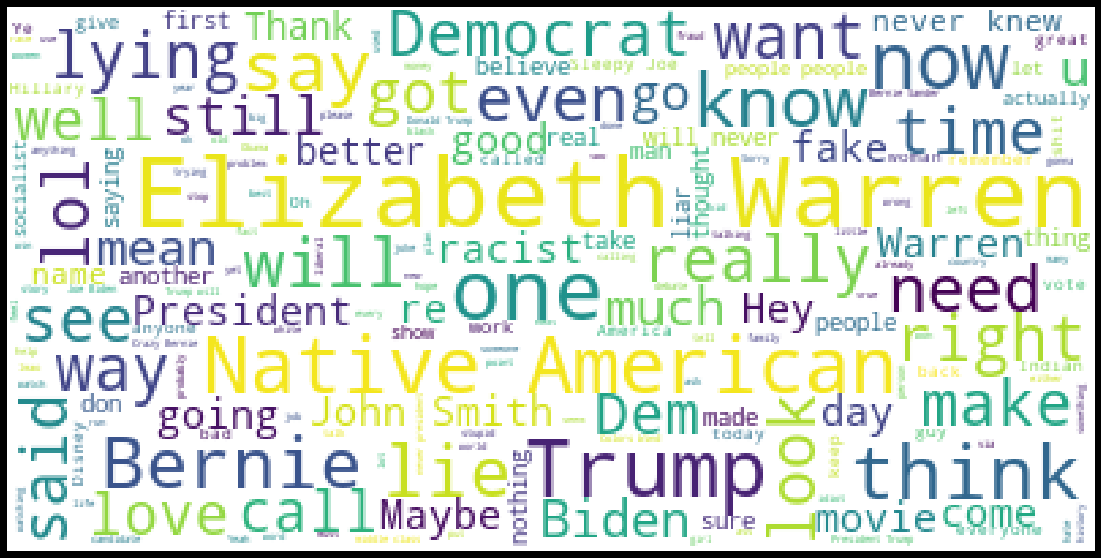

In [42]:
# clean_text_for_wordcloud(df, col, search_term)

P_wordcloud_df  = clean_text_for_wordcloud(P_raw_df, 'text', 'Pocahontas')

get_wordcloud(P_wordcloud_df, 'text')

In [14]:
P_sxy_tweet_objects = get_tweet_object('("Pocahontas" and "sexy")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [15]:
P_sxy_raw_df = tweet_obj_to_df(P_sxy_tweet_objects)

print(len(P_sxy_raw_df), '\n')

print(P_sxy_raw_df.head())

1785 

                                                text           author
0  @TheEliza2 @KerJTalit Lady 1 was VERY SEXY. La...       pipandbaby
1  My #clip - Sexy Bound and Gagged Pocahontas Jo...  TheAddieJuniper
2  this sexy woman is such a ugh!!!! I really nee...        louhontas
3  @kiethharings oh I know,,, wearing native Amer...  jesusbutthiccer
4  @WerewolfBelly The amount of times ive been to...      blufoxthing


In [17]:
P_sxy_raw_df.to_csv('P_sxy_raw_df_Jan_26_2020.csv')

In [16]:
P_hlw_tweet_objects = get_tweet_object('("Pocahontas" and "halloween")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [18]:
P_hlw_raw_df = tweet_obj_to_df(P_hlw_tweet_objects)

print(len(P_hlw_raw_df), '\n')

print(P_hlw_raw_df.head())

4339 

                                                text           author
0  @kiethharings oh I know,,, wearing native Amer...  jesusbutthiccer
1  I’m getting vivid memories of when I dressed u...  PurpleInsomnia_
2  Wish they'd give pocahontas the attention it d...      ifwonheonly
3  @ScottAdamsSays When I hear her described as P...    AssemblyMetal
4  @Bonnaroo @nikolelew every time I hear grace p...  fatwonderwoman6


In [19]:
P_hlw_raw_df.to_csv('P_hlw_raw_df_Jan_26_2020.csv')

In [20]:
P_hot_tweet_objects = get_tweet_object('("Pocahontas" and "hot")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [21]:
P_hot_raw_df = tweet_obj_to_df(P_hot_tweet_objects)

print(len(P_hot_raw_df), '\n')

print(P_hot_raw_df.head())

2365 

                                                text           author
0  @Joshua4NPV1 My feeling is that Trump would bu...       NewMutator
1  How and in what world do you think this is in ...       absentmuse
2  @leftcoaster4 @Dcl_60 @jdmnd4 Didnt like what ...     donna_harter
3  @DonaldJTrumpJr Bernie probably told Pocahonta...  SassyTrumpPence
4  Pocahontas is the worst. And I'd still rather ...  thethiccqueenXL


In [22]:
P_hot_raw_df.to_csv('P_hot_raw_df_Jan_26_2020.csv')

In [23]:
P_disney_tweet_objects = get_tweet_object('("Pocahontas" and "disney")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [25]:
P_dsn_raw_df = tweet_obj_to_df(P_disney_tweet_objects)

print(len(P_dsn_raw_df), '\n')

print(P_dsn_raw_df.head())

25000 

                                                text           author
0  pocahontas and mulan were the best disney prin...      DIZZYJOONIE
1  @Animated_Antic Crowd: “Hey Disney, since your...   MisterSureShot
2  Do you want to know the ONLY Disney film that ...  Yeenie_Mcbeenie
3  @ChiSportsHomer @Education4Libs @jappyheadedho...   Magic8Ball2020
4  “You think the only people who are people, are...     LilLovelyKid


In [26]:
P_dsn_raw_df.to_csv('P_dsn_raw_df_Jan_26_2020.csv')

In [27]:
P_M_tweet_objects = get_tweet_object('("Pocahontas" and "Matoaka")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [28]:
P_M_raw_df = tweet_obj_to_df(P_M_tweet_objects)

print(len(P_M_raw_df), '\n')

print(P_M_raw_df.head())

830 

                                                text         author
0  @TheBandGreport @Skrub_3 @MikeWiseguy Of cours...    DonTochillo
1  hey lefties! stop calling elizabeth warren Poc...        neoputa
2  fictional Disney Pocahontas is based on a real...    kazooareyou
3  @DeadDogLake @vissersixxx On the Public Indian...      KirosAuld
4  EPUB Free Pocahontas: Alias Matoaka, and Her D...  philarsonsasi


In [29]:
P_M_raw_df.to_csv('P_M_raw_df_Jan_26_2020.csv')

In [30]:
M_tweet_objects = get_tweet_object('Matoaka', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [31]:
M_raw_df = tweet_obj_to_df(M_tweet_objects)

print(len(M_raw_df), '\n')

print(M_raw_df.head())

13885 

                                                text         author
0  @BoggieBamf I’m rioting if they so much as hin...      popolvuzh
1  @Irish_Atheist I'm going to correct this, afte...      SallyMa42
2  Family Fun – Tribe Women’s Basketball https://...     MatoakaPTA
3  me waddling over to matoaka art studio in 25 d...  pesso_jessica
4  @SenWarren @SenateGOP Senator Matoaka proclaim...       traderva


In [32]:
M_raw_df.to_csv('M_raw_df_Jan_26_2020.csv')

Wordcloud Generated at:  2020-01-26 03:37:41.757132  EST


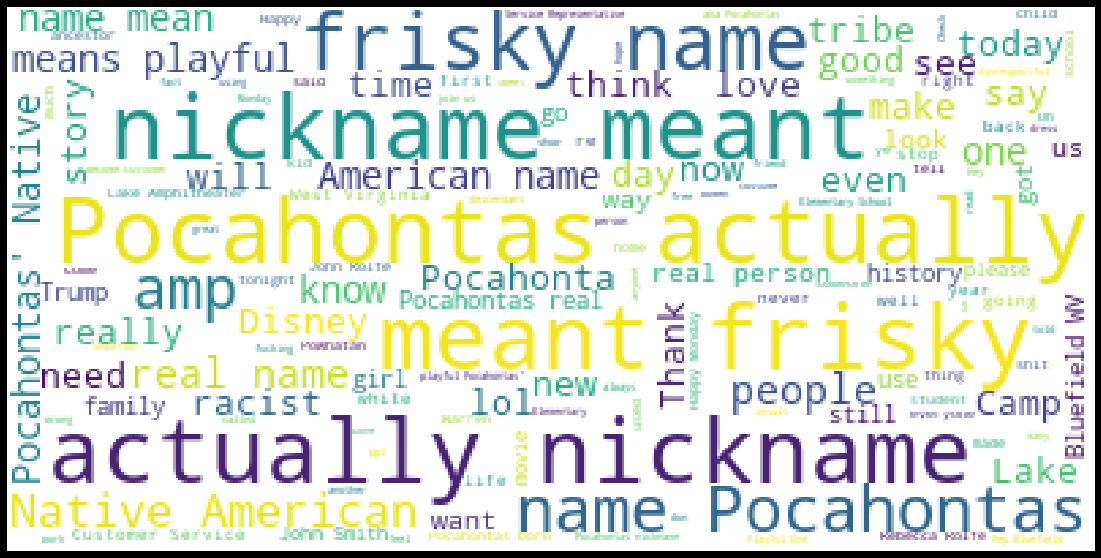

In [43]:
# wordcloud from tweets containing 'Matoaka'

M_wordcloud_df = clean_text_for_wordcloud(M_raw_df, 'text', 'Matoaka')

get_wordcloud(M_wordcloud_df, 'text')

In [33]:
LMA_tweet_objects = get_tweet_object('LeaveMatoakaAlone', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [35]:
LMA_raw_df = tweet_obj_to_df(LMA_tweet_objects)

print(len(LMA_raw_df), '\n')

print(LMA_raw_df.head())

1092 

                                                text          author
0  @IBJIYONGI @ewarren Pocahontas as a Slur hits ...       KirosAuld
1  @miaelizabeth202 @PrincessKnightD The NCAI con...  powhatannative
2  @AMikofsky @MikePrysner @YNB @Ancestry @ewarre...  moniquedhooghe
3  @IndigenousAI Examples: \n\n#ChangeTheName\n#N...  ThunderingElks
4  @Wilson__Valdez @eclecticbrotha The term "Poca...    wtf_imtooold


In [36]:
LMA_raw_df.to_csv('LMA_raw_df_Jan_26_2020.csv')

Wordcloud Generated at:  2020-01-26 03:38:45.543480  EST


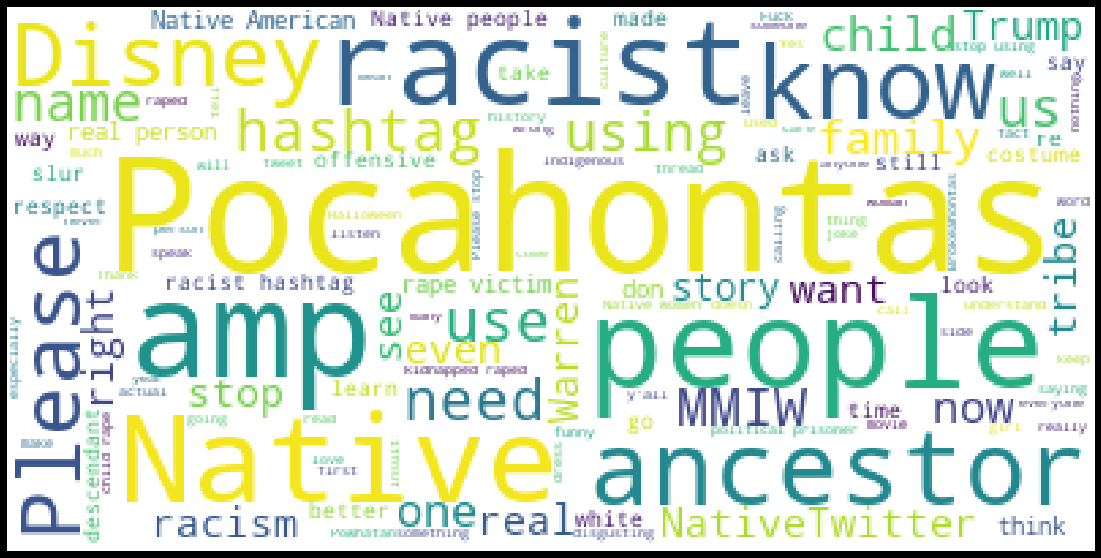

In [44]:
# wordcloud for tweets containing 'LeaveMatoakaAlone'

LMA_wordcloud_df = clean_text_for_wordcloud(LMA_raw_df, 'text', 'Matoaka')

get_wordcloud(LMA_wordcloud_df, 'text')

In [37]:
P_warren_tweet_objects = get_tweet_object('("Pocahontas" and "warren")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [38]:
P_warren_raw_df = tweet_obj_to_df(P_warren_tweet_objects)

print(len(P_warren_raw_df), '\n')

print(P_warren_raw_df.head())

25000 

                                                text           author
0  Pocahontas Warren,  Bernie Agitates, Obama, AD...  whittington2017
1  @Krissonzo @skycake10 @joshuarolson @planoneck...     StarToasters
2  Socialism is not fair. No questions about it, ...         lsenft33
3  Pocahontas Warren,  Bernie Agitates, Obama, AD...  whittington2017
4  When Warren dookies on stage after Trump calls...       jabbaLhunt


In [39]:
P_warren_raw_df.to_csv('P_warren_raw_df_Jan_26_2020.csv')

In [ ]:
# 'P_raw_df_Jan_25_2020.csv'

P_warren_df = pd.read_csv

### using tweepy for moment-by-monent queries

In [21]:
def get_keys(consumer_key_file, consumer_secret_file,
             access_token_file, access_secret_file):
    
    '''imports access keys from a hidden file'''
    
    with open(consumer_key_file) as f:
        
        consumer_key = f.read().strip()
    
    with open(consumer_secret_file) as f:
        
        consumer_secret = f.read().strip()
        
    with open(access_token_file) as f:
        
        access_token = f.read().strip()
    
    with open(access_secret_file) as f:
        
        access_token_secret = f.read().strip()
    
    return consumer_key, consumer_secret, access_token, access_token_secret


def get_oauth(consumer_key, consumer_secret, access_token, access_token_secret):
    
    '''
    takes credentials as variables, initializes OAuth
    
    returns Oauth/api object
    
    '''
    
    auth = tw.OAuthHandler(consumer_key, consumer_secret)
    
    auth.set_access_token(access_token, access_token_secret)
    
    api = tw.API(auth, wait_on_rate_limit=True)
    
    return api


def get_tweets_object(search_term, date_since, number_of_tweets, api):
    
    '''
    initializes tweepy Cursor object with search term & date provided
    
    returns tweets as cursor object
    
    '''
    
    tweets_object = tw.Cursor(api.search,
                      q=search_term,
                      lang='en',
                      since=date_since).items(number_of_tweets)
    
    return tweets_object


def build_dictionary(tweets_object, include_retweets=True):
    
    '''
    takes tweepy Cursor object
    
    returns dictionary
    
    include_retweets=True is the default setting, includes retweets
    
    setting include_retweets=False will append tweets excluding retweets.
    
    '''
    
    tweets_dict = {'text':[],
                  'screen_name':[],
                  'likes':[],
                  'retweets':[]}
    
    for tweet in tweets_object:
        
        if include_retweets:
        
            tweets_dict['text'].append(tweet.text)
        
            tweets_dict['screen_name'].append(tweet.user.screen_name)
        
            tweets_dict['likes'].append(tweet.favorite_count)
        
            tweets_dict['retweets'].append(tweet.retweet_count)
        
        else:
        
            #if (not tweet.retweeted) and ('RT @' not in tweet.text):
        
            if not tweet.retweeted:
            
            #if 'RT @' not in tweet.text:
        
                tweets_dict['text'].append(tweet.text)
        
                tweets_dict['screen_name'].append(tweet.user.screen_name)
        
                tweets_dict['likes'].append(tweet.favorite_count)
        
                tweets_dict['retweets'].append(tweet.retweet_count)
        
    return tweets_dict

def dict_to_dataframe(tweets_dictionary):
    
    '''
    takes dictionary as input
    
    returns dataframe with NaN rows removed
    
    '''
    
    df = pd.DataFrame(tweets_dictionary)
    
    df = df.dropna()
    
    return df

In [61]:
def tweets_to_df_pipeline(consumer_key_file, consumer_secret_file,
                          access_token_file, access_secret_file,
                          search_term, date_since, number_of_tweets, include_retweets):
    '''
    takes credential files & search terms
    
    gets tweet object
    
    builds dictionary
    
    returns dataframe
    
    '''
    
    # get credentials
    consumer_key, consumer_secret, access_token, access_token_secret = get_keys(consumer_key_file, consumer_secret_file, access_token_file, access_secret_file)
    
    # get API object
    api = get_oauth(consumer_key, consumer_secret, access_token, access_token_secret)
    
    # get tweets object
    tweets_object = get_tweets_object(search_term, date_since, number_of_tweets, api)
    
    # build a dictionary
    tweets_dict = build_dictionary(tweets_object, include_retweets)
    
    # create a dataframe
    tweets_df = dict_to_dataframe(tweets_dict)
    
    return tweets_df
        

In [62]:
def clean_tweets(doc, search_term):
    
    '''
    takes input document:
    
    * lowercases
    * removes non-alpha characters
    * removes tweet artifacts (screen names, 'RT', '@')
    * removes stopwords
    * tokenizes
    
    returns clean document
    
    '''
    
    # remove punctuation
    
    doc = ''.join(c if c.isalpha() else ' ' for c in doc)
    
    # tokenize
    
    split_tokens = doc.split()
    
    # remove twitter artifacts & search term
    
    cleaner_tokens = [word.lower() for word in split_tokens
                     if 'http' not in word
                     and '@' not in word
                     and '<' not in word
                     and 'RT' not in word
                     and 'amp' not in word.lower()
                     and search_term.lower() not in word.lower()
                     ]
    
    # remove stopwords
    
    clean_tokens = [t for t in cleaner_tokens if t.lower() not in stopwords.words('english')]
    
    return clean_tokens

def get_vocab_df(docs):
    
    '''
    takes a list of clean docs
    
    returns dataframe with vocabulary counts
    returns total words
    returns unique words
    
    '''
    
    vocab = []
    
    for document in docs:
        
        for word in document:
            
            vocab.append(word)
    
    total_words = len(vocab)
    
    word_count = Counter(vocab)
    
    num_unique_words = len(word_count)
    
    # Counter() is a dictionary, has to be converted as such
    
    vocab_df = pd.DataFrame.from_dict(word_count, orient='index')
    
    # rearrange the dataframe so it's easy to index/use
    # sort by number of times a word appears
    # add an index & rename columns
    
    vocab_df = vocab_df.sort_values(by=0, ascending=False)
    
    vocab_df = vocab_df.reset_index().rename(columns={'index':'word', 0:'count'})

    return vocab_df, total_words, num_unique_words


def clean_text_for_wordcloud(df, col, search_term):

    '''
    takes input dataframe

    * applies light cleaning for wordcloud
    * removes search term, non alpha characters & tweet artifacts

    returns dataframe with clean text
    
    '''
    
    for i in range(len(df[col])):
        
        df[col][i] = ' '.join([word for word in df[col][i].split()
                               if 'http' not in word and '@' not in word
                               and '<' not in word and 'RT' not in word
                               and 'amp' not in word.lower() and 'rt' not in word
                               and search_term.lower() not in word.lower()])
        
    return df

def get_wordcloud(df, col):
    
    '''
    takes a clean dataframe
    
    generates wordcloud
    
    '''
    
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords,
                          random_state=0).generate(' '.join([i for i in df[col]]))
    
    plt.figure(figsize=(20, 10), facecolor='k')
    
    plt.imshow(wordcloud)
    
    plt.axis('off')
    
    # print date/time wordcloud is generated
    
    datetime_obj = datetime.datetime.now()
    
    time_delta = datetime.timedelta(hours=5)
    
    time_now_EST = datetime_obj - time_delta
    
    print('Wordcloud Generated at: ', time_now_EST, ' EST')

In [63]:
def text_processing_pipeline(df, col, search_term):
    
    '''
    
    takes dataframe, column as input
    returns:
    
    * wordcloud
    * vocab dataframe & counts of total/unique words
    * clean & tokenized dataframe of tweets for additional analysis
    
    '''
    
    # get the wordcloud 1st
    
    clean_df_for_wordcloud = clean_text_for_wordcloud(df, col, search_term)
    
    get_wordcloud(clean_df_for_wordcloud, col)
    
    # get super clean vdf for vocab work
    
    clean_df_for_vocab = df[col].apply(clean_tweets, args=(search_term,))
    
    # get vocab df & related variables
    # vocab_df.sort_values(by=0, ascending=False), total_words, num_unique_words

    vocab_df, total_words, num_unique_words = get_vocab_df(clean_df_for_vocab)
    
    
    return clean_df_for_vocab, vocab_df, total_words, num_unique_words 

In [39]:
def full_pipeline(consumer_key_file, consumer_secret_file,
                          access_token_file, access_secret_file,
                          search_term, date_since, number_of_tweets, col, include_retweets):
    
    tweets_df = tweets_to_df_pipeline(consumer_key_file, consumer_secret_file,
                                    access_token_file, access_secret_file,
                                    search_term, date_since, number_of_tweets,
                                    include_retweets)
    
    clean_df_for_vocab, vocab_df, total_words, num_unique_words = text_processing_pipeline(tweets_df,col,search_term)
    
    # print out the date/time tweets were pulled & worldcloud generated
    
    datetime_Object = datetime.datetime.now()

    time_delta = datetime.timedelta(hours=5)
    
    date_time = datetime_Object - time_delta

    print('Date/Time: ', datetime_Object - time_delta, ' EST')

    return tweets_df, clean_df_for_vocab, vocab_df, total_words, num_unique_words 


Wordcloud Generated at:  2020-02-07 21:03:00.146882  EST
Date/Time:  2020-02-07 21:03:00.349105  EST


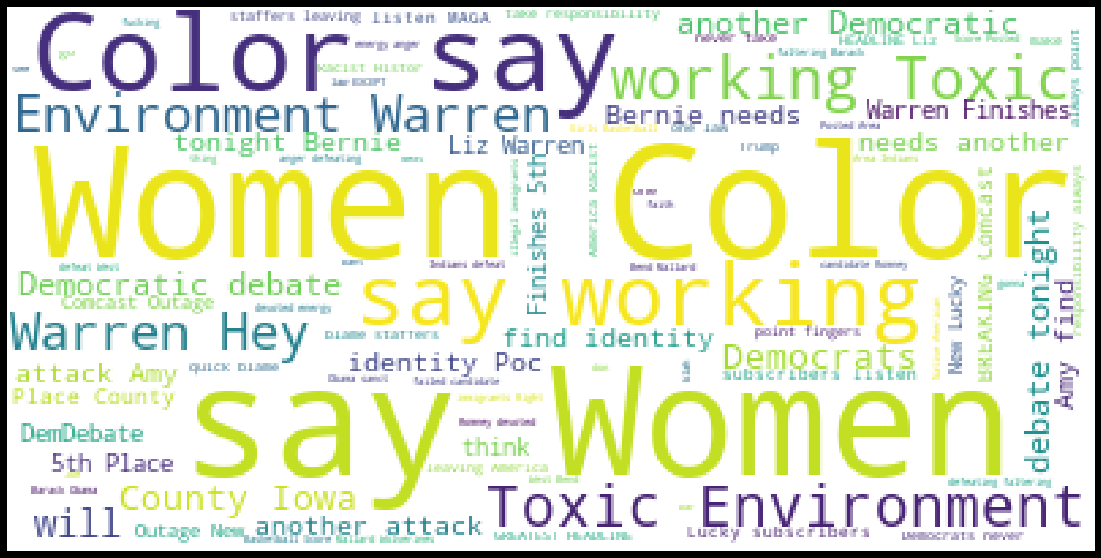

In [33]:


main_test_df, clean_df_for_vocab, test_vocab_df, test_total_words, test_unique_words = full_pipeline('consumer_key.txt','consumer_secret.txt',
                                                                                                     'access_token.txt','access_secret.txt',
                                                                                                     'pocahontas','2015-01-01',100,'text',
                                                                                                     include_retweets=False)



In [ ]:
main_test_df.to_csv() 

clean_df_for_vocab.to_csv() 

test_vocab_df.to_csv()

Wordcloud Generated at:  2020-02-07 21:26:07.659251  EST
Date/Time:  2020-02-07 21:26:09.796367  EST


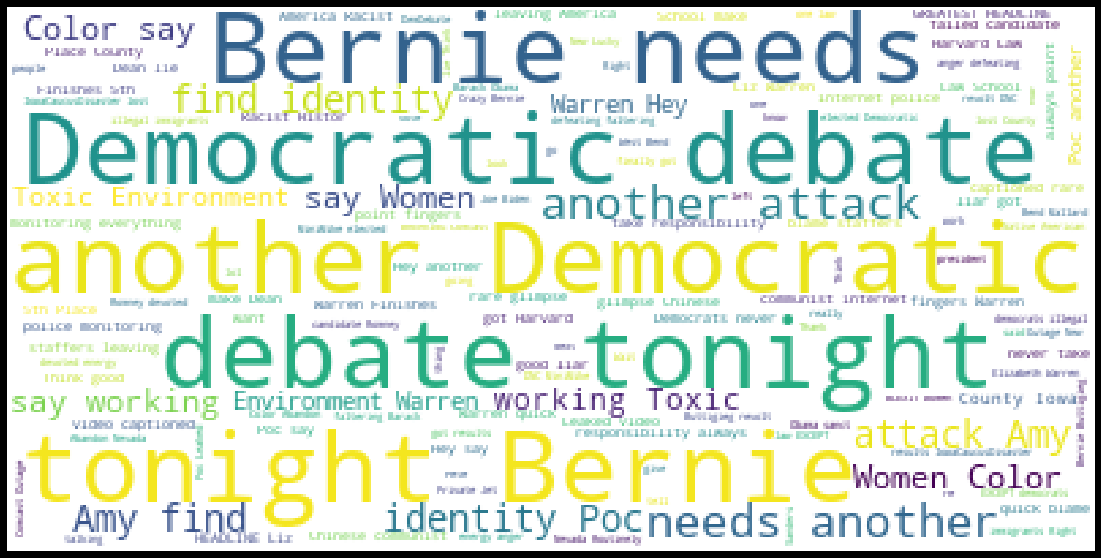

In [42]:
main_test_df, clean_df_for_vocab, test_vocab_df, test_total_words, test_unique_words = full_pipeline('consumer_key.txt','consumer_secret.txt',
                                                                                                     'access_token.txt','access_secret.txt',
                                                                                                     'pocahontas','2015-01-01',1000,'text',
                                                                                                     include_retweets=False)

#print(date_time)

In [ ]:
main_test_df.to_csv()
clean_df_for_vocab.to_csv() 
test_vocab_df.to_csv()

Wordcloud Generated at:  2020-02-07 21:38:29.954504  EST
Date/Time:  2020-02-07 21:38:32.148750  EST


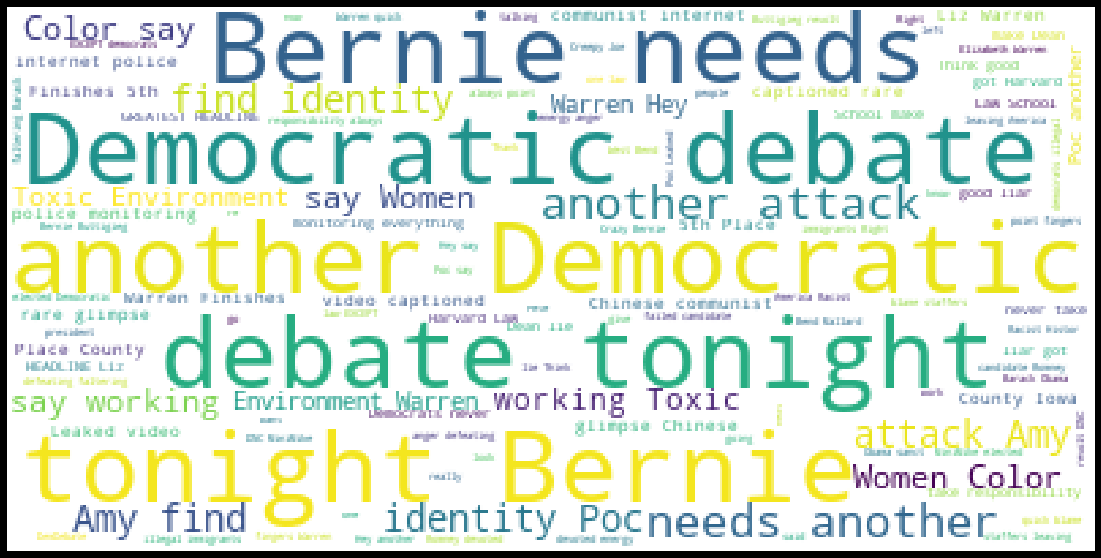

In [45]:

raw_df2, clean_df_for_vocab2, vocab_df2, total_words2, unique_words2 = full_pipeline('consumer_key.txt','consumer_secret.txt',
                                                                                'access_token.txt','access_secret.txt',
                                                                                'pocahontas','2015-01-01',1000,'text',
                                                                                include_retweets=False)




In [ ]:
raw_df2.to_csv() 
clean_df_for_vocab2.to_csv()
vocab_df2.to_csv()

Wordcloud Generated at:  2020-02-07 22:30:33.762336  EST
Date/Time:  2020-02-07 22:30:36.042013  EST


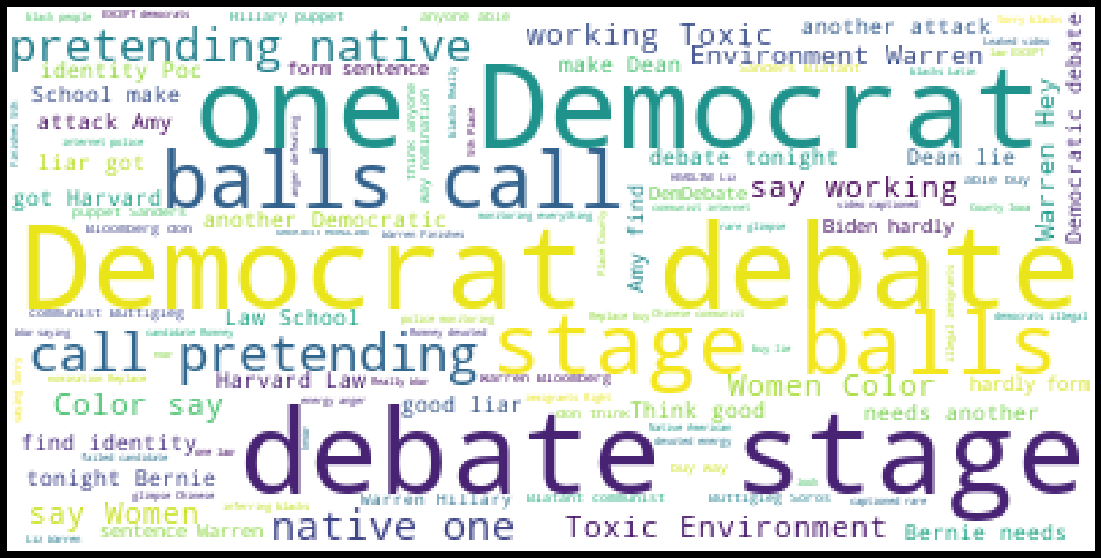

In [47]:

raw_df3, clean_df_for_vocab3, vocab_df3, total_words3, unique_words3 = full_pipeline('consumer_key.txt','consumer_secret.txt',
                                                                                'access_token.txt','access_secret.txt',
                                                                                'Pocahontas','2015-01-01',1000,'text',
                                                                                include_retweets=False)




In [ ]:
raw_df3.to_csv() 
clean_df_for_vocab3.to_csv() 
vocab_df3.to_csv()

## Cherokee Mentions

#### Democratic Debates Shape Cherokee Mentions Due to Warren's Claims

I created an instantaneous word cloud from tweets containing the word "Cherokee" immediately following the February 7th, 2020 democratic debate, around 10:30 pm EST. The most frequent vocabulary words found in the tweets show that up until shortly after the debate the biggest news around the word "Cherokee" was the tribe's [donation of several culturally vital varieties of seeds](https://anadisgoi.com/archive/2756-cherokee-nation-first-tribe-in-u-s-to-send-heirloom-seeds-to-global-seed-vault-in-norway) to the [Svalbard Global Seed Vault](https://www.nordgen.org/sgsv/), as reported by The Guardian [in a story](https://www.theguardian.com/world/2020/feb/07/cherokee-nation-seeds-arctic-vault-svalbard) dated February 7th, 12:27 EST. As the Cherokee Nation is only the second Indigenous tribe to contribute to the vault, and the seeds contributed [predate European arrival in North America](https://www.cherokeephoenix.org/Article/index/114057), it makes sense that this news would dominate.

Wordcloud Generated at:  2020-02-07 22:31:43.296004  EST
Date/Time:  2020-02-07 22:31:45.268687  EST


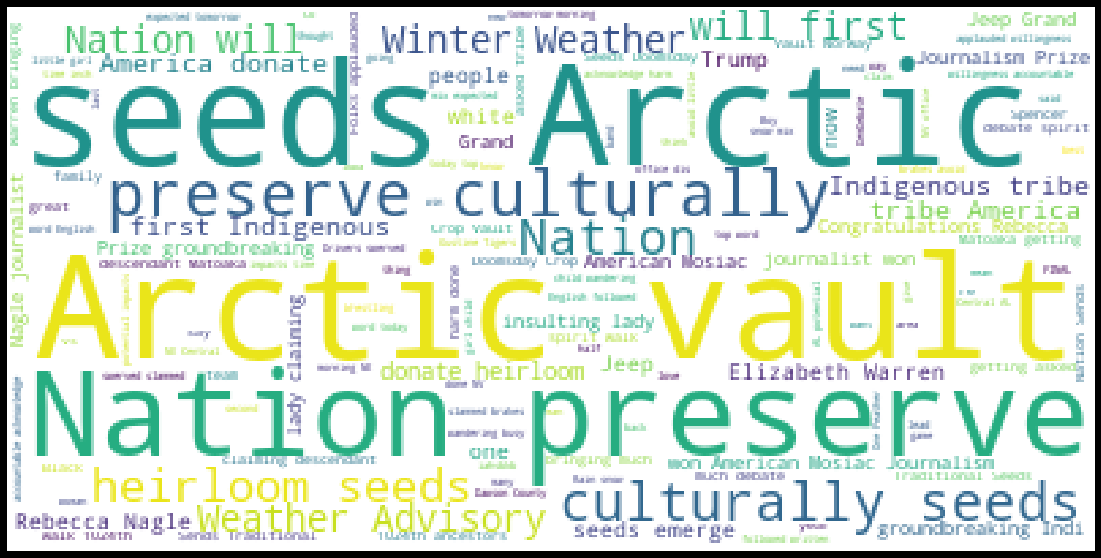

In [48]:

raw_df4, clean_df_for_vocab4, vocab_df4, total_words4, unique_words4 = full_pipeline('consumer_key.txt','consumer_secret.txt',
                                                                                'access_token.txt','access_secret.txt',
                                                                                'Cherokee','2015-01-01',1000,'text',
                                                                                include_retweets=False)




In [ ]:
raw_df4.to_csv() 
clean_df_for_vocab4.to_csv() 
vocab_df4.to_csv()

#### Twelve Hours Later: 'Cherokee' Becomes Inseparable from the Democratic Debate

However by shortly after 10:30 am February 8th, **just twelve hours later**, a word cloud created using the same methodology demonstrates how the debate had worked its way in to Cherokee mentions: alongside words like "seeds", "culturally" and "preserve" hashtags related to the presidential election are prominent in the dataset. Diluting mentions of Cherokee heritage we can see the terms *Bernie2016* and *Bernie2020*, referencing 2020 democratic presidential candidate Bernie Sanders.

This word cloud was generated from tweets containing the word "Cherokee". There was no other reference or marker for politics, any political candidate, or the democratic debate. The ability to query tweets containing "Cherokee" and in real time see tweets directly linked to the 2020 elections is clear evidence of the deeply-entrenched nature of Warren's lies regarding her ethnicty.


The cost of cultural appropriation is sometimes difficult to directly measure. However in this case the data shows that while the Cherokee Nation was making history preserving North American cultural heritage, a politician's dishonesty unfortunately took center stage.


Wordcloud Generated at:  2020-02-08 10:37:14.004351  EST
Date/Time:  2020-02-08 10:37:15.905756  EST


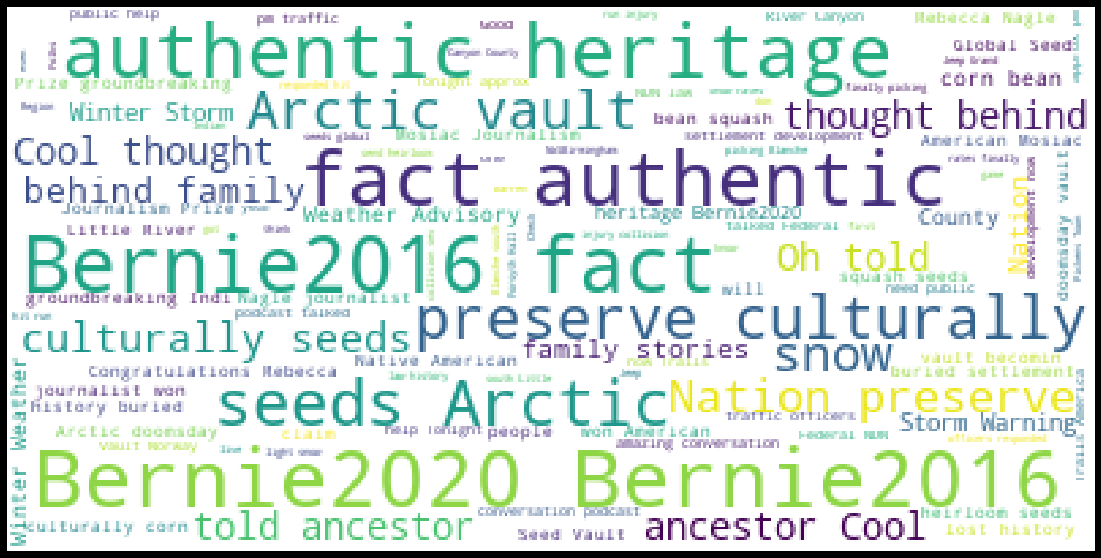

In [49]:

raw_df5, clean_df_for_vocab5, vocab_df5, total_words5, unique_words5 = full_pipeline('consumer_key.txt','consumer_secret.txt',
                                                                                'access_token.txt','access_secret.txt',
                                                                                'Cherokee','2015-01-01',1000,'text',
                                                                                include_retweets=False)




Wordcloud Generated at:  2020-02-08 13:42:46.667633  EST
Date/Time:  2020-02-08 13:42:48.518165  EST


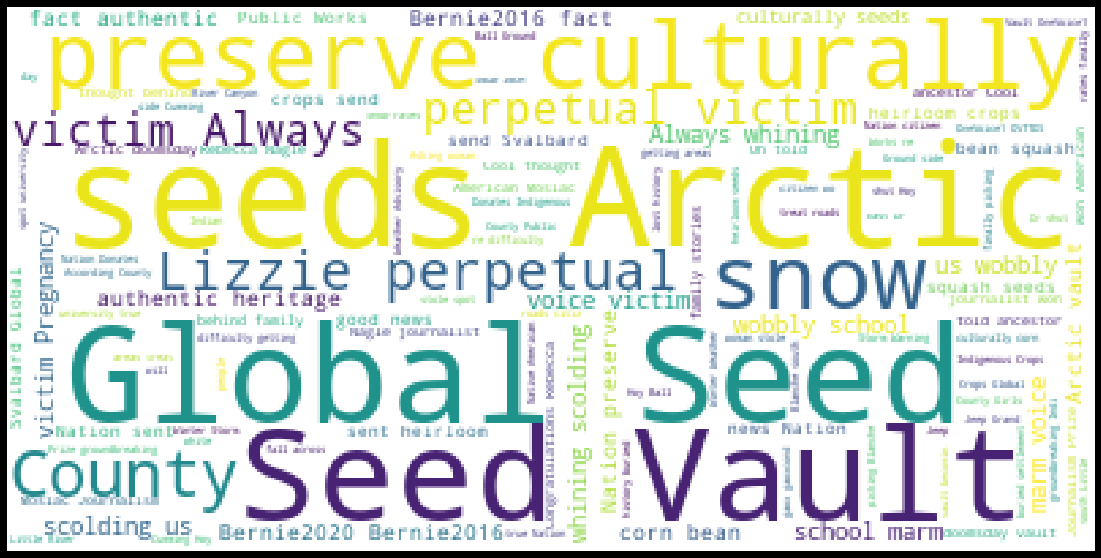

In [50]:

raw_df6, clean_df_for_vocab6, vocab_df6, total_words6, unique_words6 = full_pipeline('consumer_key.txt','consumer_secret.txt',
                                                                                'access_token.txt','access_secret.txt',
                                                                                'Cherokee','2015-01-01',1000,'text',
                                                                                include_retweets=False)




Wordcloud Generated at:  2020-02-08 14:58:33.670719  EST
Date/Time:  2020-02-08 14:58:35.551800  EST


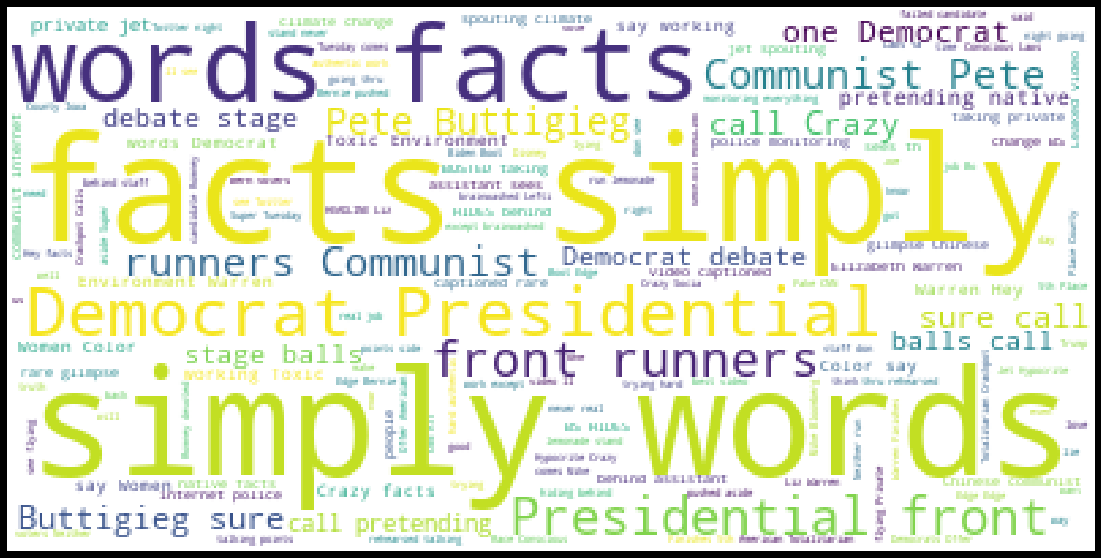

In [53]:

raw_df7, clean_df_for_vocab7, vocab_df7, total_words7, unique_words7 = full_pipeline('consumer_key.txt','consumer_secret.txt',
                                                                                'access_token.txt','access_secret.txt',
                                                                                'Pocahontas','2015-01-01',1000,'text',
                                                                                include_retweets=False)




#### One More Try for Authentic Cherokee Mentions: After the February 25th Debate

The February 25th Democratic debate was overshadowed by an open letter to Senator Warren published on Wednesday February 26th. The letter, signed by over *two hundred* Cherokee and other Native leaders, laid out several priorities for Senator Warren to set a public example regarding her ancestry claims.

In response the Warren campaign quickly released a 12-page letter containing multiple references to Natives who approve of the senator, as well as her own policy initiatives, in addition to an apology. In this letter, Warren continued to insist that she received no professional  benefit whatsoever from her claims of Native ancestry, despite her having been touted as Harvard's first "womxn of color" law professor. Crucially, Warren failed to admit (as requested) that her claims of Cherokee & Delaware Native heritage were false.

Although the word cloud below was generated within the typical post-debate time window, this particular dataset shows the impact of Cherokee citizens' voices in its most important concepts: while Warren's response & apology still occupy a prominent place in the corpus, words associated with tribal soveriegnty such as "citizens" & "Nation" feature prominently--and powerfully--within the data.

When the voices of Cherokee citizens are amplified, tribal sovereignty emerges as the theme.


Wordcloud Generated at:  2020-02-26 19:55:15.496918  EST
Date/Time:  2020-02-26 19:55:17.550018  EST


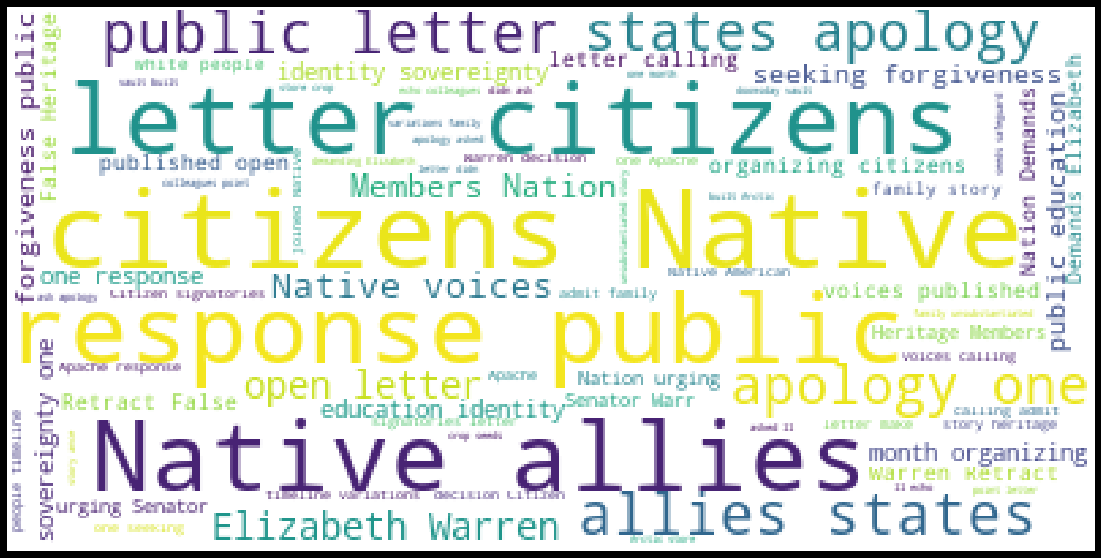

In [131]:
# ᎪᏢᏍᎩ == "build"

ᎪᏢᏍᎩ_df, ᎪᏢᏍᎩ_clean_df_for_vocab, ᎪᏢᏍᎩ_vocab_df, ᎪᏢᏍᎩ_total_words, ᎪᏢᏍᎩ_unique_words = full_pipeline('consumer_key.txt','consumer_secret.txt',
                                                                                                        'access_token.txt','access_secret.txt',
                                                                                                        'Cherokee','2015-01-01',1000,'text',
                                                                                                        include_retweets=False)




#### modified function for requests 

In [86]:
def get_tweet_object_2(search_term, start_date, end_date, num_of_tweets, include_retweets=True):
    
    '''
    takes:
    
    * date range
    * screen name
    * number of tweets to return (500 per page)
       
    input search term as a string
    
    input search range as datetime.datetime(20xx, 1, 20)
    
    include_retweets defaults is True. to exclude retweets set to False.
    
    returns: 
    
    * tweets object with tweets containing the search term
    * date & time of the dataset creation as a string
   
    '''
    
    
    search_args = searchtweets.load_credentials('twitter_keyz.yaml',
                                                yaml_key='search_tweets_api',
                                                env_overwrite=False)
    
    if include_retweets:
        
        search_term = search_term + ' lang:en'
    
    else:
        
        search_term = search_term + ' lang:en -is:retweet'
        
    
    
    rule = searchtweets.gen_rule_payload(search_term,
                                         results_per_call=500,
                                         from_date=start_date.strftime('%Y-%m-%d'),
                                         to_date=end_date.strftime('%Y-%m-%d'))     
        
    tweet_objects = []
    
    rs = searchtweets.ResultStream(rule_payload=rule,
                                   max_results=num_of_tweets,
                                   max_pages=math.ceil(num_of_tweets / 500.0),
                                   **search_args)
    
    start_time = time.time()
    
    # error handling & rate limiting for requests
    
    try:
        
        # generator 

        for i, tweet_object in enumerate(rs.stream(), start=1):
            
            # check every 500 requests, ie every page
        
            if i % 500 == 0:
            
                now = time.time()
                
                # four second delay
            
                if now < start_time + 4:
                
                    time.sleep(4 - (now - start_time))
                
                    start_time = time.time()
                
            tweet_objects.append(tweet_object)
    
    except Exception as e:
        
        print("Error from Twitter API: %s. Fetched %d tweet_objects" % (e, len(tweet_objects)))
    
    datetime_Object = datetime.datetime.now()

    time_delta = datetime.timedelta(hours=5)

    date_time = datetime_Object - time_delta

    date_str = str(thing)
    
    return tweet_objects, date_str

In [83]:
def tweet_obj_to_df_2(tweet_objects):
    
    tweet_dict = {'text': [],
                  'author': [],
                  'created_at': [],
                  'bio': [],
                  'generator': [],
                  'location': [],
                  'hashtags': []
                 }
    
    for tweet in tweet_objects:
        
        tweet_dict['text'].append(tweet.all_text)
        
        tweet_dict['author'].append(tweet.screen_name)
        
        tweet_dict['created_at'].append(tweet.created_at_datetime)
        
        tweet_dict['bio'].append(tweet.bio)
        
        tweet_dict['generator'].append(tweet.generator)
        
        tweet_dict['location'].append(tweet.geo_coordinates)
        
        tweet_dict['hashtags'].append(tweet.hashtags)
        
    
    tweets_df = pd.DataFrame(tweet_dict)
    
    return tweets_df

In [76]:
def tweets_to_csv(df, search_term, time_str):
    
    df.to_csv(search_term + '_' + time_str + '.csv')

In [79]:
#def pipeline(search_term, datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

def pipeline(search_term, start_time, end_time, num_tweets, include_retweets):
    
    tweet_objects, time_str = get_tweet_object_2(search_term, start_time, end_time, num_tweets, include_retweets)

    raw_df = tweet_obj_to_df_2(tweet_objects)
    
    tweets_to_csv(raw_df, search_term, time_str)

    print(len(raw_df), '\n')

    print(raw_df.head())
    
    return raw_df

#### tweets from the day of the debate

set to day of thru day after just to make sure we get them all

there are 2,684 tweets containing the word "Cherokee" from this roughly 24 hour period.

In [84]:
C_df_1 = pipeline('Cherokee', datetime.datetime(2020,2,7), datetime.datetime(2020,2,9), 100000, include_retweets=False)


Grabbing bearer token from OAUTH


2684 

                                                text           author  \
0  This is SO COOL. And apparently the Cherokee N...         erinbiba   
1  Why don’t we talk about your coach getting in ...       The706Crew   
2  @AtheistBender @thehill I'm Native Cherokee an...       HindsShala   
3  You didn’t renature recipes to Southwestern St...  IdentityEuleria   
4  @quackelroys This is the HMS Beagle, a gorgeou...        optional_   

           created_at                                                bio  \
0 2020-02-08 23:59:58  Freelance Science Journalist - National Geogra...   
1 2020-02-08 23:59:20                       Official Crunk Crew for DCHS   
2 2020-02-08 23:58:55  Country farmer gal Native Cherokee.   MAGA WWG...   
3 2020-02-08 23:55:02  CEO: Gemologista; Dans Le Bain; FWNBD\nChurch ...   
4 2020-02-08 23:53:56                kill the body and the head will die   

                                           generator location hashtags  
0  {'link': 'https://mob

#### expanded search range: 'Cherokee'

To get more tweets & a more representative sample, I also searched using an expanded 1-month date range that included both the February 7th and the January 14th democratic party debates.

This search, covering a roughly 30 day period, returned over 38,000 tweets containing the word "Cherokee". It is important to note that there is no guarantee that all these tweets represent direct references to one of the three Cherokee tribes.

That is in fact the point here--that a name referring to three federally recognized tribes is very often not associated with the tribes at all. 

In [85]:
C_df_2 = pipeline('Cherokee', datetime.datetime(2020,1,9), datetime.datetime(2020,2,9), 100000, include_retweets=False)


Grabbing bearer token from OAUTH


38738 

                                                text           author  \
0  This is SO COOL. And apparently the Cherokee N...         erinbiba   
1  Why don’t we talk about your coach getting in ...       The706Crew   
2  @AtheistBender @thehill I'm Native Cherokee an...       HindsShala   
3  You didn’t renature recipes to Southwestern St...  IdentityEuleria   
4  @quackelroys This is the HMS Beagle, a gorgeou...        optional_   

           created_at                                                bio  \
0 2020-02-08 23:59:58  Freelance Science Journalist - National Geogra...   
1 2020-02-08 23:59:20                       Official Crunk Crew for DCHS   
2 2020-02-08 23:58:55  Country farmer gal Native Cherokee.   MAGA WWG...   
3 2020-02-08 23:55:02  CEO: Gemologista; Dans Le Bain; FWNBD\nChurch ...   
4 2020-02-08 23:53:56                kill the body and the head will die   

                                           generator location hashtags  
0  {'link': 'https://mo

In [ ]:
#C_df_2 = pipeline('Cherokee', datetime.datetime(2020,1,9), datetime.datetime(2020,2,9), 100000, include_retweets=False)


In [109]:
def try_terms(tribe_name):
    
    '''
    takes input tribe name
    
    searches twitter searchtweets API for terms matching
    tribe name AND each term tested
    
    saves CSVs for all terms tested
    
    NOTE: uses 2nd query method and dataset construction
    
    returns:
    
    * 1 large dataframe containing all terms tested
    
    '''
    
    term_list = ['warren', 'grandmother',
                'grandma', 'indian blood',
                'not offended', 'cheekbones',
                'squaw', 'princess', 'sexy']
    
    raw_df = pd.DataFrame()
    
    for term in term_list:
        
            # create search string
        
            search_term = '("' + tribe_name + '" and "' + term + '")'
            
            tweet_objects, date_str = get_tweet_object_2(search_term, datetime.datetime(2007,1,1), datetime.datetime(2020,2,9), 10000, include_retweets=False)
            
            tweet_obj_df = tweet_obj_to_df_2(tweet_objects)
            
            # printout length for each term w term itself
            # save individual dfs as CSVs
            
            tweet_obj_df.to_csv(tribe_name + '_' + term + '_' + date_str + '.csv')
            
            print(term + ' dataframe length: ' + str(len(tweet_obj_df)))

            raw_df = raw_df.append(tweet_obj_df)
            
            raw_df.to_csv(tribe_name + '_raw_dataframe_' + date_str + '.csv')

            print('total dataframe length: ' + str(len(raw_df)), '\n')

            print(raw_df.head(20))
            
    return raw_df

#### Do these terms exist in connection with the word "Cherokee"?

A quick test revealed that every one of the tested terms appears in conjunction with the word "Cherokee" fairly frequently on twitter--each term easily returned 100 tweets.

In [103]:
c_test_df = try_terms('Cherokee')

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


warren dataframe length: 100
total dataframe length: 100 

                                                 text           author  \
0   @Donelsonfiles (She has neither in her book.) ...  IdentityEuleria   
1   In order to appeal to the radical left wing of...       Topsy71452   
2   @UrsulaV @NeolithicSheep @PasturesPolitic @the...      MTBinDurham   
3   @JessicaGottlieb @WendyBrandes @rabiasquared @...   GGforthepeople   
4   @LaurenGilhooly_ @haiku_poet @rabiasquared @ew...   GGforthepeople   
5   @realDonaldTrump I can tell you friends I’ve g...  RobertPilking17   
6   I can tell you friends I’ve got much more Cher...  RobertPilking17   
7   @TrumpWarRoom @DineshDSouza @ewarren Elizabeth...        JohnD2231   
8   @seal_song @College_Goblin @franklinleonard @E...      BabakBackup   
9   @AJawort Warren reached out privately and cont...    BigTimePaiute   
10  @BenMank77 What debate were you watching Myrna...  ThoughtCrimin12   
11  @augustcohen_nyc @Samothecat If I were a Democ...

Grabbing bearer token from OAUTH


grandmother dataframe length: 100
total dataframe length: 200 

                                                 text           author  \
0   @Donelsonfiles (She has neither in her book.) ...  IdentityEuleria   
1   In order to appeal to the radical left wing of...       Topsy71452   
2   @UrsulaV @NeolithicSheep @PasturesPolitic @the...      MTBinDurham   
3   @JessicaGottlieb @WendyBrandes @rabiasquared @...   GGforthepeople   
4   @LaurenGilhooly_ @haiku_poet @rabiasquared @ew...   GGforthepeople   
5   @realDonaldTrump I can tell you friends I’ve g...  RobertPilking17   
6   I can tell you friends I’ve got much more Cher...  RobertPilking17   
7   @TrumpWarRoom @DineshDSouza @ewarren Elizabeth...        JohnD2231   
8   @seal_song @College_Goblin @franklinleonard @E...      BabakBackup   
9   @AJawort Warren reached out privately and cont...    BigTimePaiute   
10  @BenMank77 What debate were you watching Myrna...  ThoughtCrimin12   
11  @augustcohen_nyc @Samothecat If I were a Dem

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


indian blood dataframe length: 100
total dataframe length: 400 

                                                 text           author  \
0   @Donelsonfiles (She has neither in her book.) ...  IdentityEuleria   
1   In order to appeal to the radical left wing of...       Topsy71452   
2   @UrsulaV @NeolithicSheep @PasturesPolitic @the...      MTBinDurham   
3   @JessicaGottlieb @WendyBrandes @rabiasquared @...   GGforthepeople   
4   @LaurenGilhooly_ @haiku_poet @rabiasquared @ew...   GGforthepeople   
5   @realDonaldTrump I can tell you friends I’ve g...  RobertPilking17   
6   I can tell you friends I’ve got much more Cher...  RobertPilking17   
7   @TrumpWarRoom @DineshDSouza @ewarren Elizabeth...        JohnD2231   
8   @seal_song @College_Goblin @franklinleonard @E...      BabakBackup   
9   @AJawort Warren reached out privately and cont...    BigTimePaiute   
10  @BenMank77 What debate were you watching Myrna...  ThoughtCrimin12   
11  @augustcohen_nyc @Samothecat If I were a De

Grabbing bearer token from OAUTH


not offended dataframe length: 100
total dataframe length: 500 

                                                 text           author  \
0   @Donelsonfiles (She has neither in her book.) ...  IdentityEuleria   
1   In order to appeal to the radical left wing of...       Topsy71452   
2   @UrsulaV @NeolithicSheep @PasturesPolitic @the...      MTBinDurham   
3   @JessicaGottlieb @WendyBrandes @rabiasquared @...   GGforthepeople   
4   @LaurenGilhooly_ @haiku_poet @rabiasquared @ew...   GGforthepeople   
5   @realDonaldTrump I can tell you friends I’ve g...  RobertPilking17   
6   I can tell you friends I’ve got much more Cher...  RobertPilking17   
7   @TrumpWarRoom @DineshDSouza @ewarren Elizabeth...        JohnD2231   
8   @seal_song @College_Goblin @franklinleonard @E...      BabakBackup   
9   @AJawort Warren reached out privately and cont...    BigTimePaiute   
10  @BenMank77 What debate were you watching Myrna...  ThoughtCrimin12   
11  @augustcohen_nyc @Samothecat If I were a De

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


squaw dataframe length: 100
total dataframe length: 700 

                                                 text           author  \
0   @Donelsonfiles (She has neither in her book.) ...  IdentityEuleria   
1   In order to appeal to the radical left wing of...       Topsy71452   
2   @UrsulaV @NeolithicSheep @PasturesPolitic @the...      MTBinDurham   
3   @JessicaGottlieb @WendyBrandes @rabiasquared @...   GGforthepeople   
4   @LaurenGilhooly_ @haiku_poet @rabiasquared @ew...   GGforthepeople   
5   @realDonaldTrump I can tell you friends I’ve g...  RobertPilking17   
6   I can tell you friends I’ve got much more Cher...  RobertPilking17   
7   @TrumpWarRoom @DineshDSouza @ewarren Elizabeth...        JohnD2231   
8   @seal_song @College_Goblin @franklinleonard @E...      BabakBackup   
9   @AJawort Warren reached out privately and cont...    BigTimePaiute   
10  @BenMank77 What debate were you watching Myrna...  ThoughtCrimin12   
11  @augustcohen_nyc @Samothecat If I were a Democ... 

Grabbing bearer token from OAUTH


princess dataframe length: 100
total dataframe length: 800 

                                                 text           author  \
0   @Donelsonfiles (She has neither in her book.) ...  IdentityEuleria   
1   In order to appeal to the radical left wing of...       Topsy71452   
2   @UrsulaV @NeolithicSheep @PasturesPolitic @the...      MTBinDurham   
3   @JessicaGottlieb @WendyBrandes @rabiasquared @...   GGforthepeople   
4   @LaurenGilhooly_ @haiku_poet @rabiasquared @ew...   GGforthepeople   
5   @realDonaldTrump I can tell you friends I’ve g...  RobertPilking17   
6   I can tell you friends I’ve got much more Cher...  RobertPilking17   
7   @TrumpWarRoom @DineshDSouza @ewarren Elizabeth...        JohnD2231   
8   @seal_song @College_Goblin @franklinleonard @E...      BabakBackup   
9   @AJawort Warren reached out privately and cont...    BigTimePaiute   
10  @BenMank77 What debate were you watching Myrna...  ThoughtCrimin12   
11  @augustcohen_nyc @Samothecat If I were a Democ.

#### Beyond Toy Datasets: Up to 10,000 Tweets per Term

Since it was possible (& easy) to find 100 tweets per tested term, I increased the potential dataset size by a couple orders of magnitude in the hopes that a large enough dataset would allow a glimpse into what society means & understands using the Cherokee name online.

In [108]:
# run function again
# this time returning up to 10k tweets per term

C_terms_df = try_terms('Cherokee')

Grabbing bearer token from OAUTH


warren dataframe length: 10000
total dataframe length: 10000 

                                                 text           author  \
0   @Donelsonfiles (She has neither in her book.) ...  IdentityEuleria   
1   In order to appeal to the radical left wing of...       Topsy71452   
2   @UrsulaV @NeolithicSheep @PasturesPolitic @the...      MTBinDurham   
3   @JessicaGottlieb @WendyBrandes @rabiasquared @...   GGforthepeople   
4   @LaurenGilhooly_ @haiku_poet @rabiasquared @ew...   GGforthepeople   
5   @realDonaldTrump I can tell you friends I’ve g...  RobertPilking17   
6   I can tell you friends I’ve got much more Cher...  RobertPilking17   
7   @TrumpWarRoom @DineshDSouza @ewarren Elizabeth...        JohnD2231   
8   @seal_song @College_Goblin @franklinleonard @E...      BabakBackup   
9   @AJawort Warren reached out privately and cont...    BigTimePaiute   
10  @BenMank77 What debate were you watching Myrna...  ThoughtCrimin12   
11  @augustcohen_nyc @Samothecat If I were a Demo

Grabbing bearer token from OAUTH


grandmother dataframe length: 5557


Grabbing bearer token from OAUTH


total dataframe length: 15557 

                                                 text           author  \
0   @Donelsonfiles (She has neither in her book.) ...  IdentityEuleria   
1   In order to appeal to the radical left wing of...       Topsy71452   
2   @UrsulaV @NeolithicSheep @PasturesPolitic @the...      MTBinDurham   
3   @JessicaGottlieb @WendyBrandes @rabiasquared @...   GGforthepeople   
4   @LaurenGilhooly_ @haiku_poet @rabiasquared @ew...   GGforthepeople   
5   @realDonaldTrump I can tell you friends I’ve g...  RobertPilking17   
6   I can tell you friends I’ve got much more Cher...  RobertPilking17   
7   @TrumpWarRoom @DineshDSouza @ewarren Elizabeth...        JohnD2231   
8   @seal_song @College_Goblin @franklinleonard @E...      BabakBackup   
9   @AJawort Warren reached out privately and cont...    BigTimePaiute   
10  @BenMank77 What debate were you watching Myrna...  ThoughtCrimin12   
11  @augustcohen_nyc @Samothecat If I were a Democ...   JusticeTyrwhit   
12  @k

Grabbing bearer token from OAUTH


indian blood dataframe length: 404
total dataframe length: 18949 

                                                 text           author  \
0   @Donelsonfiles (She has neither in her book.) ...  IdentityEuleria   
1   In order to appeal to the radical left wing of...       Topsy71452   
2   @UrsulaV @NeolithicSheep @PasturesPolitic @the...      MTBinDurham   
3   @JessicaGottlieb @WendyBrandes @rabiasquared @...   GGforthepeople   
4   @LaurenGilhooly_ @haiku_poet @rabiasquared @ew...   GGforthepeople   
5   @realDonaldTrump I can tell you friends I’ve g...  RobertPilking17   
6   I can tell you friends I’ve got much more Cher...  RobertPilking17   
7   @TrumpWarRoom @DineshDSouza @ewarren Elizabeth...        JohnD2231   
8   @seal_song @College_Goblin @franklinleonard @E...      BabakBackup   
9   @AJawort Warren reached out privately and cont...    BigTimePaiute   
10  @BenMank77 What debate were you watching Myrna...  ThoughtCrimin12   
11  @augustcohen_nyc @Samothecat If I were a 

Grabbing bearer token from OAUTH


not offended dataframe length: 327


Grabbing bearer token from OAUTH


total dataframe length: 19276 

                                                 text           author  \
0   @Donelsonfiles (She has neither in her book.) ...  IdentityEuleria   
1   In order to appeal to the radical left wing of...       Topsy71452   
2   @UrsulaV @NeolithicSheep @PasturesPolitic @the...      MTBinDurham   
3   @JessicaGottlieb @WendyBrandes @rabiasquared @...   GGforthepeople   
4   @LaurenGilhooly_ @haiku_poet @rabiasquared @ew...   GGforthepeople   
5   @realDonaldTrump I can tell you friends I’ve g...  RobertPilking17   
6   I can tell you friends I’ve got much more Cher...  RobertPilking17   
7   @TrumpWarRoom @DineshDSouza @ewarren Elizabeth...        JohnD2231   
8   @seal_song @College_Goblin @franklinleonard @E...      BabakBackup   
9   @AJawort Warren reached out privately and cont...    BigTimePaiute   
10  @BenMank77 What debate were you watching Myrna...  ThoughtCrimin12   
11  @augustcohen_nyc @Samothecat If I were a Democ...   JusticeTyrwhit   
12  @k

Grabbing bearer token from OAUTH


total dataframe length: 19993 

                                                 text           author  \
0   @Donelsonfiles (She has neither in her book.) ...  IdentityEuleria   
1   In order to appeal to the radical left wing of...       Topsy71452   
2   @UrsulaV @NeolithicSheep @PasturesPolitic @the...      MTBinDurham   
3   @JessicaGottlieb @WendyBrandes @rabiasquared @...   GGforthepeople   
4   @LaurenGilhooly_ @haiku_poet @rabiasquared @ew...   GGforthepeople   
5   @realDonaldTrump I can tell you friends I’ve g...  RobertPilking17   
6   I can tell you friends I’ve got much more Cher...  RobertPilking17   
7   @TrumpWarRoom @DineshDSouza @ewarren Elizabeth...        JohnD2231   
8   @seal_song @College_Goblin @franklinleonard @E...      BabakBackup   
9   @AJawort Warren reached out privately and cont...    BigTimePaiute   
10  @BenMank77 What debate were you watching Myrna...  ThoughtCrimin12   
11  @augustcohen_nyc @Samothecat If I were a Democ...   JusticeTyrwhit   
12  @k

Grabbing bearer token from OAUTH


total dataframe length: 20139 

                                                 text           author  \
0   @Donelsonfiles (She has neither in her book.) ...  IdentityEuleria   
1   In order to appeal to the radical left wing of...       Topsy71452   
2   @UrsulaV @NeolithicSheep @PasturesPolitic @the...      MTBinDurham   
3   @JessicaGottlieb @WendyBrandes @rabiasquared @...   GGforthepeople   
4   @LaurenGilhooly_ @haiku_poet @rabiasquared @ew...   GGforthepeople   
5   @realDonaldTrump I can tell you friends I’ve g...  RobertPilking17   
6   I can tell you friends I’ve got much more Cher...  RobertPilking17   
7   @TrumpWarRoom @DineshDSouza @ewarren Elizabeth...        JohnD2231   
8   @seal_song @College_Goblin @franklinleonard @E...      BabakBackup   
9   @AJawort Warren reached out privately and cont...    BigTimePaiute   
10  @BenMank77 What debate were you watching Myrna...  ThoughtCrimin12   
11  @augustcohen_nyc @Samothecat If I were a Democ...   JusticeTyrwhit   
12  @k

Grabbing bearer token from OAUTH


total dataframe length: 22228 

                                                 text           author  \
0   @Donelsonfiles (She has neither in her book.) ...  IdentityEuleria   
1   In order to appeal to the radical left wing of...       Topsy71452   
2   @UrsulaV @NeolithicSheep @PasturesPolitic @the...      MTBinDurham   
3   @JessicaGottlieb @WendyBrandes @rabiasquared @...   GGforthepeople   
4   @LaurenGilhooly_ @haiku_poet @rabiasquared @ew...   GGforthepeople   
5   @realDonaldTrump I can tell you friends I’ve g...  RobertPilking17   
6   I can tell you friends I’ve got much more Cher...  RobertPilking17   
7   @TrumpWarRoom @DineshDSouza @ewarren Elizabeth...        JohnD2231   
8   @seal_song @College_Goblin @franklinleonard @E...      BabakBackup   
9   @AJawort Warren reached out privately and cont...    BigTimePaiute   
10  @BenMank77 What debate were you watching Myrna...  ThoughtCrimin12   
11  @augustcohen_nyc @Samothecat If I were a Democ...   JusticeTyrwhit   
12  @k

### Over 23,000 Tweets Containing Stereotypical or Offensive Themes

For this query I was able to quickly find 23,375 tweets containing at least one of the terms tested. 

These numbers represent the results of direct queries containing the name of the Cherokee tribe combined with at least one search term. Many (but not all) of these twenty-three thousand tweets can be assumed to refer directly to Native issues.

While more complex & specific text processing could further refine this dataset, I wanted to keep the results as replicable and broadly applicable as possible, so I chose to keep the processing to a minimum.

Even taken purely as correlary, the numbers are striking and difficult to ignore.

#### Sexualization & Blood Myths

Some of the most common offending themes appear in the thousands: the sexualized & derogatory term 'sexy' appears in tweets containing 'Cherokee' 1,148 times, while tweets containing 'grandma' or 'princess', many of which could be reasonably inferred to refer to common blood myths, number 2,988 and 2,089 respectively. 

Although less numerous, the deeply offensive 'sq-aw' (146 tweets) and another phrase referencing blood myths, 'indian blood' (404 tweets) both appear in the corpus.

These queries should be considered non-exhaustive; obviously there are a number of synonyms for terms like 'sexy' etc.

#### Trying More Positive Terms

In order to get a feel for the broad range of sentiment around Cherokee themes, I decided to test terms more closely and/or positively associated with the Cherokee tribes.

I wanted to see more than the stereotypical things people say online regarding Cherokee heritage & citizenship--I wanted to explore the positive associations people might have with the three Cherokee tribes.

To do this, I started by testing two terms related to Cherokee tribal citizenship & sovereignty--the word "citizen" and the word "sovereignty" itself--as well as "enrollment", a reference to the process by which one becomes a Cherokee citizen. I chose these themes because anecdotally Cherokee sovereignty over citizenship is often ignored or outright questioned by non-Natives online. Presumably a search for these terms would reveal data on public sentiment around what it means to *be* Cherokee.

In addition I searched for terms that could describe Cherokee citizens who are members of educated & well-respected professional groups, such as *'doctor', 'lawyer', 'engineer', 'professor', 'journalist',* and *'CEO'.*

Because a major contemporary stereotype against Natives in general is the assumption of a monolithic culture stuck in time, I reasoned that testing for modern, respectable occupations & terms related to professional and technical fields might provide a more accurate look at public perception of Cherokee scholars and professionals. 

Of course there are Cherokee citizens representing the three tribes in each of these fields; I wanted to see how closely public perception mirrors this reality online.


In [113]:
def try_pos_terms(tribe_name):
    
    '''
    takes input tribe name
    
    searches twitter searchtweets API for more positive terms matching
    tribe name AND each term tested
    
    saves CSVs for all terms tested
    
    NOTE: uses 2nd query method and dataset construction
    
    returns:
    
    * 1 large dataframe containing all terms tested
    
    '''
    
    term_list = ['citizen', 'sovereignty',
                'enrollment', 'doctor',
                'lawyer', 'engineer',
                'professor', 'technology',
                'journalist', 'investor', 'ceo']
    
    raw_df = pd.DataFrame()
    
    for term in term_list:
        
            # create search string
        
            search_term = '("' + tribe_name + '" and "' + term + '")'
            
            tweet_objects, date_str = get_tweet_object_2(search_term, datetime.datetime(2007,1,1), datetime.datetime(2020,2,9), 10000, include_retweets=False)
            
            tweet_obj_df = tweet_obj_to_df_2(tweet_objects)
            
            # printout length for each term w term itself
            # save individual dfs as CSVs
            
            tweet_obj_df.to_csv(tribe_name + '_' + term + '_' + date_str + '.csv')
            
            print(term + ' dataframe length: ' + str(len(tweet_obj_df)))

            raw_df = raw_df.append(tweet_obj_df)
            
            raw_df.to_csv(tribe_name + '_pos_raw_dataframe_' + date_str + '.csv')

            print('total dataframe length: ' + str(len(raw_df)), '\n')

            print(raw_df.head(20))
            
    return raw_df

In [114]:
C_pos_terms_df = try_pos_terms('Cherokee')

Grabbing bearer token from OAUTH


citizen dataframe length: 2023
total dataframe length: 2023 

                                                 text           author  \
0   @TRHLofficial The reason your heritage is so i...       liebekatie   
1   @thedrsec @js4uscongress @mitchellvii @Speaker...        natejgire   
2   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
3   Oh, you were told you have a Cherokee ancestor...   emersonsjsykes   
4   ⚖️ FRIDAY FEATURE: Osiyo! My name is Julie Com...    NationalNALSA   
5   Join us in welcoming Cherokee Nation citizen J...  CherokeePhoenix   
6   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
7   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
8   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
9   @jfkeeler @IndianCountry 1.) a Cherokee govern...    nativeopinion   
10  Congratulations to Cherokee Nation citizen and...   CherokeeNation   
11  @BigIndianGyasi If one descends from a former 

Grabbing bearer token from OAUTH


sovereignty dataframe length: 810
total dataframe length: 2833 

                                                 text           author  \
0   @TRHLofficial The reason your heritage is so i...       liebekatie   
1   @thedrsec @js4uscongress @mitchellvii @Speaker...        natejgire   
2   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
3   Oh, you were told you have a Cherokee ancestor...   emersonsjsykes   
4   ⚖️ FRIDAY FEATURE: Osiyo! My name is Julie Com...    NationalNALSA   
5   Join us in welcoming Cherokee Nation citizen J...  CherokeePhoenix   
6   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
7   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
8   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
9   @jfkeeler @IndianCountry 1.) a Cherokee govern...    nativeopinion   
10  Congratulations to Cherokee Nation citizen and...   CherokeeNation   
11  @BigIndianGyasi If one descends from a form

Grabbing bearer token from OAUTH


enrollment dataframe length: 252
total dataframe length: 3085 

                                                 text           author  \
0   @TRHLofficial The reason your heritage is so i...       liebekatie   
1   @thedrsec @js4uscongress @mitchellvii @Speaker...        natejgire   
2   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
3   Oh, you were told you have a Cherokee ancestor...   emersonsjsykes   
4   ⚖️ FRIDAY FEATURE: Osiyo! My name is Julie Com...    NationalNALSA   
5   Join us in welcoming Cherokee Nation citizen J...  CherokeePhoenix   
6   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
7   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
8   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
9   @jfkeeler @IndianCountry 1.) a Cherokee govern...    nativeopinion   
10  Congratulations to Cherokee Nation citizen and...   CherokeeNation   
11  @BigIndianGyasi If one descends from a forme

Grabbing bearer token from OAUTH


doctor dataframe length: 400
total dataframe length: 3485 

                                                 text           author  \
0   @TRHLofficial The reason your heritage is so i...       liebekatie   
1   @thedrsec @js4uscongress @mitchellvii @Speaker...        natejgire   
2   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
3   Oh, you were told you have a Cherokee ancestor...   emersonsjsykes   
4   ⚖️ FRIDAY FEATURE: Osiyo! My name is Julie Com...    NationalNALSA   
5   Join us in welcoming Cherokee Nation citizen J...  CherokeePhoenix   
6   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
7   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
8   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
9   @jfkeeler @IndianCountry 1.) a Cherokee govern...    nativeopinion   
10  Congratulations to Cherokee Nation citizen and...   CherokeeNation   
11  @BigIndianGyasi If one descends from a former ..

Grabbing bearer token from OAUTH


lawyer dataframe length: 362
total dataframe length: 3847 

                                                 text           author  \
0   @TRHLofficial The reason your heritage is so i...       liebekatie   
1   @thedrsec @js4uscongress @mitchellvii @Speaker...        natejgire   
2   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
3   Oh, you were told you have a Cherokee ancestor...   emersonsjsykes   
4   ⚖️ FRIDAY FEATURE: Osiyo! My name is Julie Com...    NationalNALSA   
5   Join us in welcoming Cherokee Nation citizen J...  CherokeePhoenix   
6   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
7   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
8   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
9   @jfkeeler @IndianCountry 1.) a Cherokee govern...    nativeopinion   
10  Congratulations to Cherokee Nation citizen and...   CherokeeNation   
11  @BigIndianGyasi If one descends from a former ..

Grabbing bearer token from OAUTH


engineer dataframe length: 260
total dataframe length: 4107 

                                                 text           author  \
0   @TRHLofficial The reason your heritage is so i...       liebekatie   
1   @thedrsec @js4uscongress @mitchellvii @Speaker...        natejgire   
2   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
3   Oh, you were told you have a Cherokee ancestor...   emersonsjsykes   
4   ⚖️ FRIDAY FEATURE: Osiyo! My name is Julie Com...    NationalNALSA   
5   Join us in welcoming Cherokee Nation citizen J...  CherokeePhoenix   
6   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
7   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
8   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
9   @jfkeeler @IndianCountry 1.) a Cherokee govern...    nativeopinion   
10  Congratulations to Cherokee Nation citizen and...   CherokeeNation   
11  @BigIndianGyasi If one descends from a former 

Grabbing bearer token from OAUTH


professor dataframe length: 620
total dataframe length: 4727 

                                                 text           author  \
0   @TRHLofficial The reason your heritage is so i...       liebekatie   
1   @thedrsec @js4uscongress @mitchellvii @Speaker...        natejgire   
2   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
3   Oh, you were told you have a Cherokee ancestor...   emersonsjsykes   
4   ⚖️ FRIDAY FEATURE: Osiyo! My name is Julie Com...    NationalNALSA   
5   Join us in welcoming Cherokee Nation citizen J...  CherokeePhoenix   
6   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
7   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
8   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
9   @jfkeeler @IndianCountry 1.) a Cherokee govern...    nativeopinion   
10  Congratulations to Cherokee Nation citizen and...   CherokeeNation   
11  @BigIndianGyasi If one descends from a former

Grabbing bearer token from OAUTH


technology dataframe length: 1211
total dataframe length: 5938 

                                                 text           author  \
0   @TRHLofficial The reason your heritage is so i...       liebekatie   
1   @thedrsec @js4uscongress @mitchellvii @Speaker...        natejgire   
2   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
3   Oh, you were told you have a Cherokee ancestor...   emersonsjsykes   
4   ⚖️ FRIDAY FEATURE: Osiyo! My name is Julie Com...    NationalNALSA   
5   Join us in welcoming Cherokee Nation citizen J...  CherokeePhoenix   
6   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
7   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
8   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
9   @jfkeeler @IndianCountry 1.) a Cherokee govern...    nativeopinion   
10  Congratulations to Cherokee Nation citizen and...   CherokeeNation   
11  @BigIndianGyasi If one descends from a form

Grabbing bearer token from OAUTH


journalist dataframe length: 127
total dataframe length: 6065 

                                                 text           author  \
0   @TRHLofficial The reason your heritage is so i...       liebekatie   
1   @thedrsec @js4uscongress @mitchellvii @Speaker...        natejgire   
2   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
3   Oh, you were told you have a Cherokee ancestor...   emersonsjsykes   
4   ⚖️ FRIDAY FEATURE: Osiyo! My name is Julie Com...    NationalNALSA   
5   Join us in welcoming Cherokee Nation citizen J...  CherokeePhoenix   
6   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
7   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
8   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
9   @jfkeeler @IndianCountry 1.) a Cherokee govern...    nativeopinion   
10  Congratulations to Cherokee Nation citizen and...   CherokeeNation   
11  @BigIndianGyasi If one descends from a forme

Grabbing bearer token from OAUTH


investor dataframe length: 34
total dataframe length: 6099 

                                                 text           author  \
0   @TRHLofficial The reason your heritage is so i...       liebekatie   
1   @thedrsec @js4uscongress @mitchellvii @Speaker...        natejgire   
2   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
3   Oh, you were told you have a Cherokee ancestor...   emersonsjsykes   
4   ⚖️ FRIDAY FEATURE: Osiyo! My name is Julie Com...    NationalNALSA   
5   Join us in welcoming Cherokee Nation citizen J...  CherokeePhoenix   
6   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
7   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
8   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
9   @jfkeeler @IndianCountry 1.) a Cherokee govern...    nativeopinion   
10  Congratulations to Cherokee Nation citizen and...   CherokeeNation   
11  @BigIndianGyasi If one descends from a former .

Grabbing bearer token from OAUTH


ceo dataframe length: 540
total dataframe length: 6639 

                                                 text           author  \
0   @TRHLofficial The reason your heritage is so i...       liebekatie   
1   @thedrsec @js4uscongress @mitchellvii @Speaker...        natejgire   
2   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
3   Oh, you were told you have a Cherokee ancestor...   emersonsjsykes   
4   ⚖️ FRIDAY FEATURE: Osiyo! My name is Julie Com...    NationalNALSA   
5   Join us in welcoming Cherokee Nation citizen J...  CherokeePhoenix   
6   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
7   @SoutheastNative @robyyynb @JuleaSarah @rebecc...      GameFoodGuy   
8   @GameFoodGuy @robyyynb @JuleaSarah @rebeccanag...  SoutheastNative   
9   @jfkeeler @IndianCountry 1.) a Cherokee govern...    nativeopinion   
10  Congratulations to Cherokee Nation citizen and...   CherokeeNation   
11  @BigIndianGyasi If one descends from a former ...  

#### One Third the Size: Stereotypes Outnumbered Positive References Three Times Over

At 6,639 rows of tweets, the dataset of positive terms, including those related to Cherokee tribal sovereignty, citizenship, and professional occupations, is less than one third the size of the corpus of stereotype-themed tweets.

For each tweet containing both the word "Cherokee" as well as a reference to tribal autonomy or professional occupations, there were 3 containing a reference to at least 1 harmful stereotype or anti-sovereignty theme.

#### Exploring More Authentically Shaped Identifiers: Corpora for ᏣᎳᎩ & Tsalagi

To get a more authentic point of comparison for Cherokee attitudes I decided to test terms that many Cherokee people use to refer to themselves. The terms I tested as substitutes for the word "Cherokee" were the Syllabary characters *'ᏣᎳᎩ'* as well as their latinized transliteration, *'Tsalagi'.*

The Cherokee Syllabary is recognizable and renderable across the internet and even in software development environments such as this jupyter notebook, as well as the python and markdown code used to create this analysis. It is critically important to note here that support for Cherokee Syllabary characters such as *ᏣᎳᎩ* is a direct result of the concerted efforts of Cherokee tribes, technologists & engineers.

These facts give the absence of Cherokee engineers & technology in the online conversation a particular irony: Cherokee innovation & technology power basic-to-advanced components of the most familiar technologies today (such as wireless internet & smartphones), yet the vocabulary around these terms remains dissociated from the idea of Natives in tech. It is not unreasonable to infer that while Cherokee innovation powers the internet, the words "Cherokee" and "innovation" are not strongly associated for non-Natives.

#### Testing Tsalagi Tweets



In [127]:
T_raw_df = pipeline('Tsalagi', datetime.datetime(2007,1,1), datetime.datetime(2020,2,9), 100000, include_retweets=False)


Grabbing bearer token from OAUTH
retrying request; current status code: 429
retrying request; current status code: 429
retrying request; current status code: 429
HTTP Error code: 429: Request exceeds account’s current package request limits. Please upgrade your package and retry or contact Twitter about enterprise access.
Rule payload: {'query': 'Tsalagi lang:en -is:retweet', 'maxResults': 500, 'toDate': '202002090000', 'fromDate': '200701010000', 'next': 'eyJtYXhJZCI6MjIxMTMxNDc3MjQ3NTkwNH0='}


Error from Twitter API: . Fetched 22000 tweet_objects
22000 

                                                text       author  \
0  How interesting. She Who Was Never Tsalagi kno...      Atagahi   
1                  @SKimemia @tsalagi_ Lol I got you  lexyrobin20   
2                                  @tsalagi_ Tonight  lexyrobin20   
3  @lexyrobin20 @tsalagi_ I would like a reserved...     SKimemia   
4  @tsalagi_ Come through! I don’t wanna eat all ...  lexyrobin20   

           created_at                                                bio  \
0 2020-02-08 23:01:22  M. Rutledge: Cherokee, gay, disabled, former l...   
1 2020-02-08 21:45:24  Rom 8:28|| 1922|| UMD|| ig: lexyrobin19|| my T...   
2 2020-02-08 21:45:07  Rom 8:28|| 1922|| UMD|| ig: lexyrobin19|| my T...   
3 2020-02-08 21:31:22      she/her Army Strong 💪🏾 #UMD20 IG: Skimemia 🇰🇪   
4 2020-02-08 21:14:37  Rom 8:28|| 1922|| UMD|| ig: lexyrobin19|| my T...   

                                           generator location hash

In [ ]:
T_raw_df = pipeline('Tsalagi', datetime.datetime(2007,1,1), datetime.datetime(2020,2,9), 25000, include_retweets=False)


#### Testing ᏣᎳᎩ Tweets

The Cherokee Syllabary is displayed as unicode characters, which require some special handling. Unfortunately unicode characters are not valid file names in Linux computer systems (such as the Ubuntu operating system on which this data work was performed). Because of this, I needed a second pipeline that takes this into account.

Exclusive of retweets, I found 1,980 tweets containing the word 'ᏣᎳᎩ' in the Cherokee syllabary.

In [125]:
# unicode pipeline allows a file name to be passed in

def unicode_tweets_to_csv(df, search_term, time_str, file_name):
    
    df.to_csv(file_name + '_' + time_str + '.csv')

def unicode_pipeline(search_term, file_name, start_time, end_time, num_tweets, include_retweets):
    
    tweet_objects, time_str = get_tweet_object_2(search_term, start_time, end_time, num_tweets, include_retweets)

    raw_df = tweet_obj_to_df_2(tweet_objects)
    
    unicode_tweets_to_csv(raw_df, search_term, time_str, file_name)

    print(len(raw_df), '\n')

    print(raw_df.head())
    
    return raw_df

In [129]:
ᏣᎳᎩ_raw_df = unicode_pipeline('ᏣᎳᎩ', 'GWY', datetime.datetime(2007,1,1), datetime.datetime(2020,2,9), 50000, include_retweets=False)


Grabbing bearer token from OAUTH


1980 

                                                text         author  \
0  #100daysofCherokee 15/100\n\nToday I had my hu...   slacker_girl   
1  @powhatannative @TRHLofficial @rms432 @luvscoc...   EaglesElatis   
2  trying to incorporate ᏣᎳᎩ words and phrases in...        _dehalu   
3  @raccorns They always claim ᏣᎳᎩ... it's like t...  unruly_tuples   
4  @TRHLofficial @Needle_of_Arya @NudaleKawonu @B...      HarjoJula   

           created_at                                                bio  \
0 2020-02-08 03:24:00  Reconnecting Cherokee/Choctaw. Also generic wh...   
1 2020-02-08 01:29:36  Memes for NTVTWT, talons for daayyys & T-shirt...   
2 2020-02-07 22:54:25                                          land back   
3 2020-02-07 10:05:07  #DecolonizeTech #MMIW #ProtectMaunaKea\nSDE .@...   
4 2020-02-07 04:42:23  Mvskoke•Chahta•Hoçak• | Espoketis Omes Kerresk...   

                                           generator location  \
0  {'link': 'https://mobile.twitter.com', 'n

In [ ]:
# TODO
# word clouds & vocab

# M_wordcloud_df = clean_text_for_wordcloud(M_raw_df, 'text', 'Matoaka')
# get_wordcloud(M_wordcloud_df, 'text')

# ᏣᎳᎩ_raw_df

#### Creating a Corpus Around Cherokee Citizenship

To find tweets more authentically reflecting the realities of everyday Cherokee lives, I wanted to use to a query that would reflect Cherokee sovereignty. to do this, I chose to use the tandem search terms "Cherokee" and "citizen", a reference to tribal citizenship in one of the three Cherokee tribes.

I named this dataset ᏣᎳᎩ ᎡᎲᎢ, for 'Cherokee citizen', using the syllabary for the variable name in honor of the Cherokee engineers, technologists, & other leaders who made possible this Indigenous language's inclusion in state of the art software engineering. There are few better metaphors for Native ingenuity & resilience than the ability to use this ancient natural (human) language to communicate with a sophisticated, modern, & dynamically interpreted machine language. The `ᏣᎳᎩ_ᎡᎲᎢ` dataset represents a unity between Indigenous & modern that has always existed.

#### ᏣᎳᎩ ᎡᎲᎢ (Cherokee Citizen) Tweets


In [130]:
# '("Cherokee" and "citizen")' == Cherokee + citizen query

ᏣᎳᎩ_ᎡᎲᎢ = pipeline('("Cherokee" and "citizen")', datetime.datetime(2007,1,1), datetime.datetime(2020,2,9), 50000, include_retweets=False)

Grabbing bearer token from OAUTH


2008 

                                                text          author  \
0  @TRHLofficial The reason your heritage is so i...      liebekatie   
1  @thedrsec @js4uscongress @mitchellvii @Speaker...       natejgire   
2  @SoutheastNative @robyyynb @JuleaSarah @rebecc...     GameFoodGuy   
3  Oh, you were told you have a Cherokee ancestor...  emersonsjsykes   
4  ⚖️ FRIDAY FEATURE: Osiyo! My name is Julie Com...   NationalNALSA   

           created_at                                                bio  \
0 2020-02-08 08:54:28  Esthetician, progressive, chihuahua mama, citi...   
1 2020-02-07 21:59:23  I like maps, cooking, politics and policy, not...   
2 2020-02-07 18:29:52  Normal life account for @humanthefixer a daily...   
3 2020-02-07 18:00:17  1st Amendment Staff Attorney @ACLU, host of “A...   
4 2020-02-07 17:22:50  Founded in 1970 to promote the study of Federa...   

                                           generator location hashtags  
0  {'link': 'https://mobile.tw